In [2]:
import numpy as np
import pandas as pd
import os
from wechat_red_bag_simulation.sim_competition import RedBag
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

import seaborn as sns
sns.set(style="whitegrid")

img_dir = 'images'

# Algorithm for generating money

$n_0$ people draw money from a money pool containing $M_0$ dollars:

Let $X_n$ be the remaining money in the pool after the $n$-th draw
($X \in [0, M_0]$, $0$-th draw means no draw has occurred), and uniform
random variable $K \sim \mathcal{U}(0, 1)$.

Let's define the algorithm to generate the money of the $i$-th draw:

$ M_i = $\begin{cases}
\max(0.01, K \frac{X_i}{n_c(i)}) & i=1,2,3,\dots n_0 - 1 \\
X_i & i = n_0 \\
\end{cases}

where $n_c(i)$ is the current number of players who haven't drawn, so
$n_c(i) = n_0 - i + 1$.

So $ M_i = $\begin{cases}
\max(0.01, K \frac{X_i}{n_0 - i + 1}) & i=1,2,3,\dots n_0 - 1 \\
X_i & i = n_0 \\
\end{cases}

In [3]:
def sim_trial(n_players: int, money: float, trial_i: int):
    """
    :return: [order, money, trial]
    """
    rb = RedBag(n_players, money)
    money = np.asarray([rb.get_money() for _ in range(n_players)]).reshape(n_players, 1)
    trial = np.ones((n_players, 1), dtype=int) * trial_i
    order = np.arange(n_players, dtype=int).reshape(n_players, 1)
    return np.hstack([order, money, trial])


def sim_trials(n_trials=200, n_players=10, money=66.0):
    np.random.seed(1024)
    data = np.vstack([sim_trial(n_players, money, i) for i in range(n_trials)])
    data = pd.DataFrame(data, columns=['order', 'money', 'trial'])
    data = data.astype({'order': int, 'money': float, 'trial': int})
    return data

data = sim_trials()
data

,order,money,trial
0,0,8.54,0
1,1,12.72,0
2,2,5.80,0
3,3,7.32,0
4,4,6.31,0
...,...,...,...
1995,5,8.19,199
1996,6,3.84,199
1997,7,7.12,199
1998,8,9.17,199


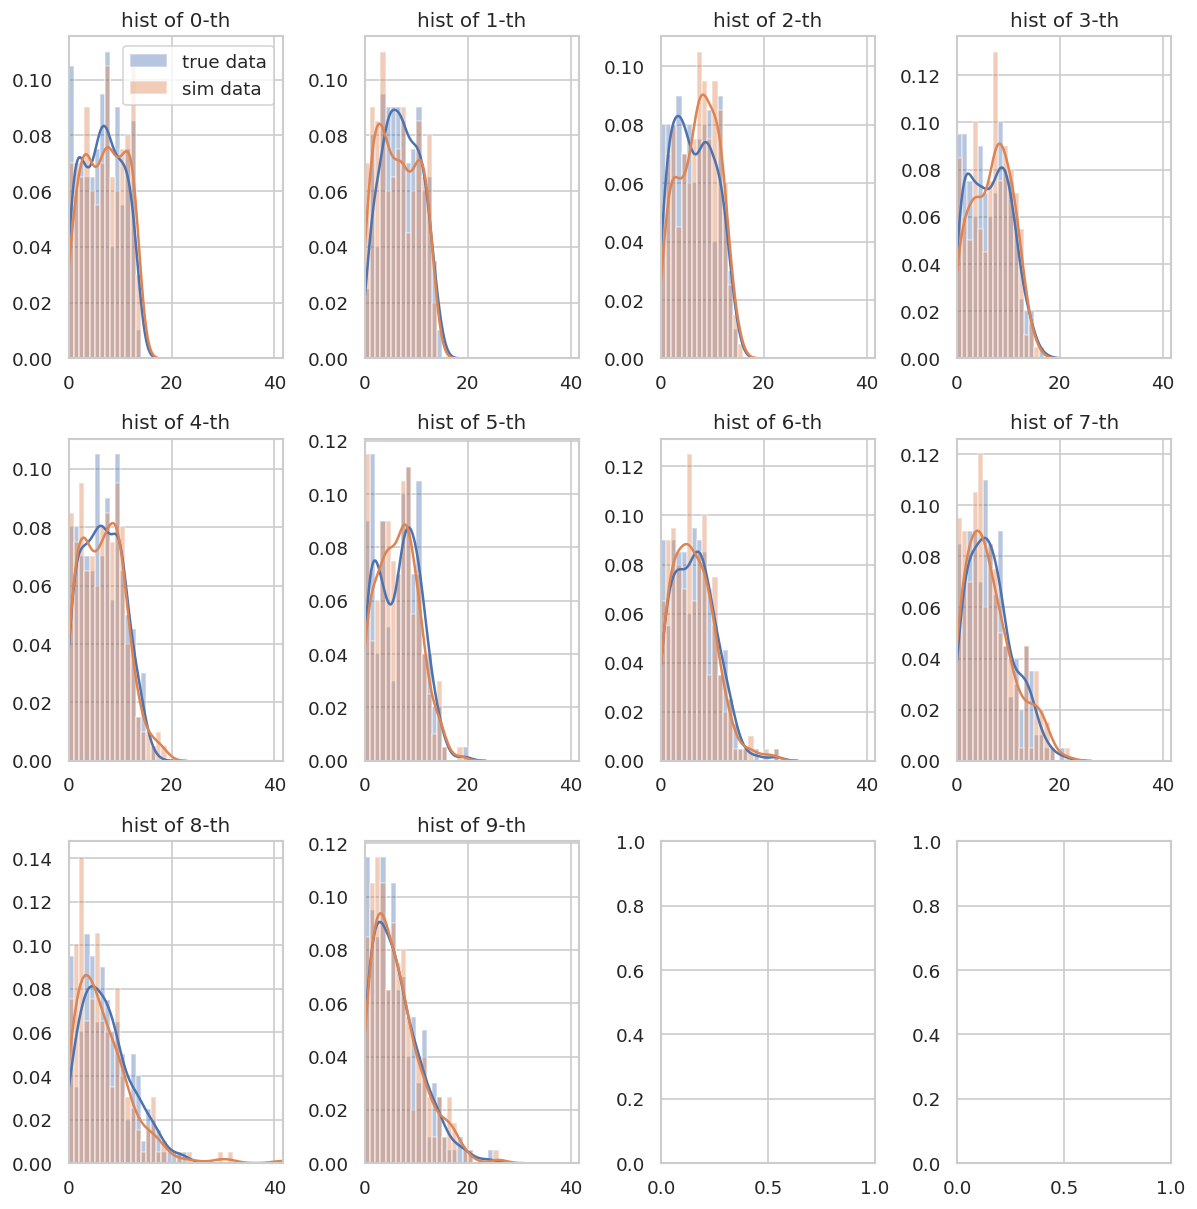

In [4]:
def plot_hist_for_players(data1, data2, bin_size: float = 1.0):
    fig, axs = plt.subplots(3, 4)
    fig.set_size_inches(10.24, 10.24)
    axs = axs.flat
    xlim = max(np.max(data1.money), np.max(data2.money))
    bins = np.arange(0.0, xlim + 0.1, step=bin_size)
    for i in range(10):
        _data1 = data1[data1.order == i].money.values
        _data2 = data2[data2.order == i].money.values
        sns.distplot(_data1, bins=bins, label="true data", ax=axs[i])
        sns.distplot(_data2, bins=bins, label="sim data", ax=axs[i])
        axs[i].set_title('hist of {}-th'.format(i))
        axs[i].set_xlim([0, xlim])
    axs[0].legend()
    fig.tight_layout()
    plt.savefig(os.path.join(img_dir, "distribution-true-and-sim.png"))
    plt.show()

data_true = pd.read_csv('data_df.csv', index_col=0)
plot_hist_for_players(data_true, data)

$H_0$: Our algorithm of generating money create the same distribution as
the one that the experiment data is sampled from.

So we reject $H_0$ if $p < 1\% $, where $p$
is obtained by calculating Kolmogorov-Smirnov statistic on 2 samples data.

See [kstest.py](kstest.py)

# Luckiest & Unluckiest Players

In [5]:
data_df = pd.read_csv('data_df.csv', index_col=0)
data_df.order = data_df.order.astype(int)
data_df.trial = data_df.trial.astype(int)
data_df.describe()

,order,money,trial
count,2000.000,2000.000000,2000.000000
mean,4.500,6.600000,99.500000
std,2.873,4.143568,57.748744
min,0.000,0.050000,0.000000
25%,2.000,3.210000,49.750000
50%,4.500,6.360000,99.500000
75%,7.000,9.550000,149.250000
max,9.000,24.100000,199.000000


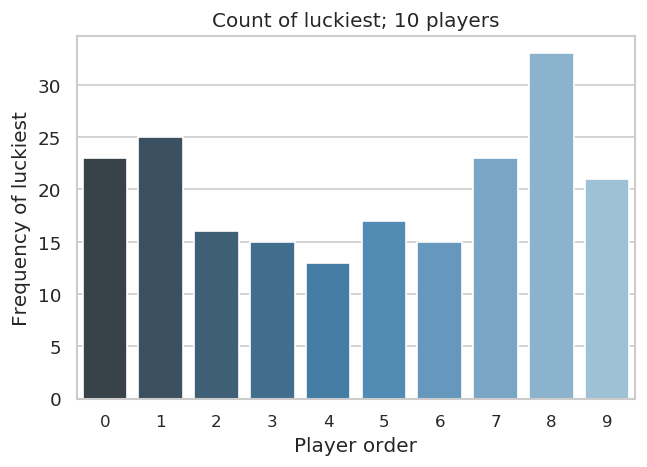

In [6]:
def plot_lucky(d: pd.DataFrame, plot_prefix=''):
    n_p = len(d.order.unique())
    idx = d.groupby(['trial'])['money'].transform(max)
    idx = idx == d['money']
    lucky = d[idx]
    n_lucky = lucky.groupby(['order']).order.count()
    lucky = pd.DataFrame({'order': n_lucky.index, 'n_lucky': n_lucky.values})

    fig, ax = plt.subplots()
    sns.barplot(x='order', y='n_lucky', data=lucky,
                label='Lucky', ax=ax, palette="Blues_d")
    ax.set_ylabel('Frequency of luckiest')
    ax.set_xlabel('Player order')
    ax.set_title('Count of luckiest; {} players'.format(n_p))
    # We change the fontsize of ticks label 
    ax.tick_params(axis='x', which='major', labelsize=10)
    # ax.legend()
    plt.savefig(os.path.join(img_dir, plot_prefix + 'lucky-{}-players.png'.format(n_p)))
    plt.show()

plot_lucky(data_df, 'true-data-')

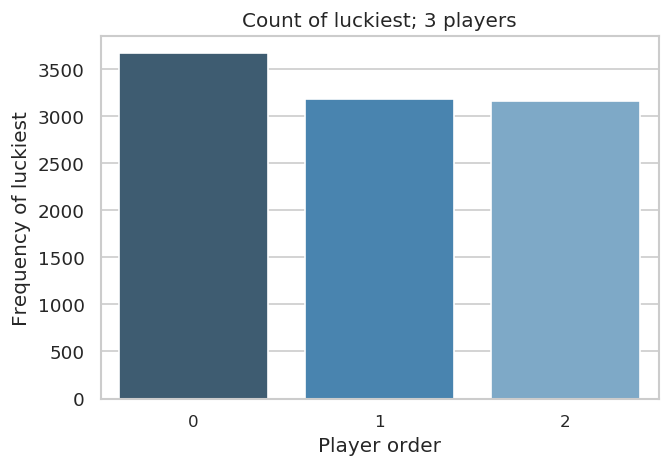

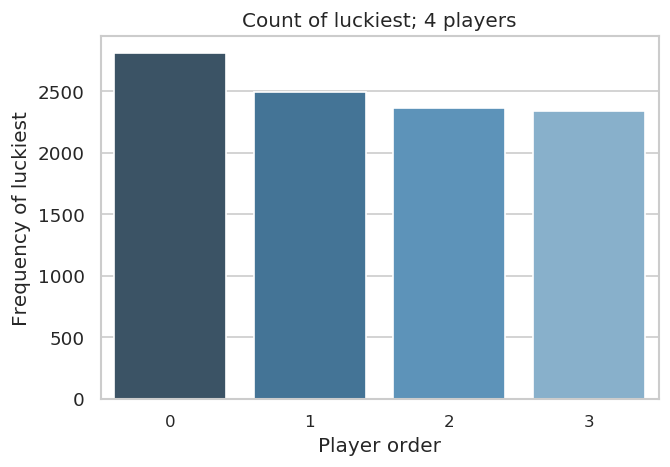

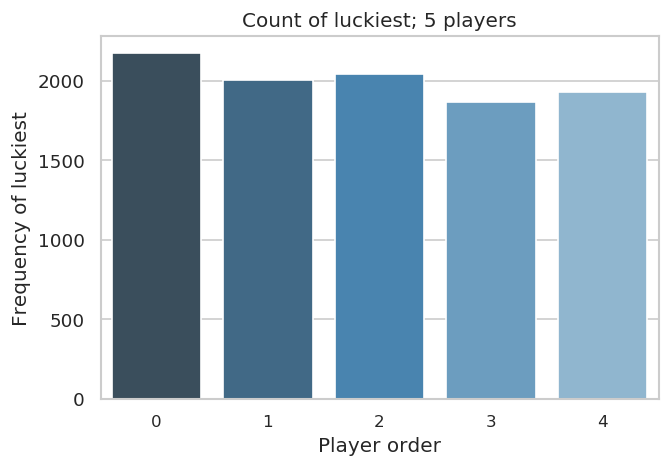

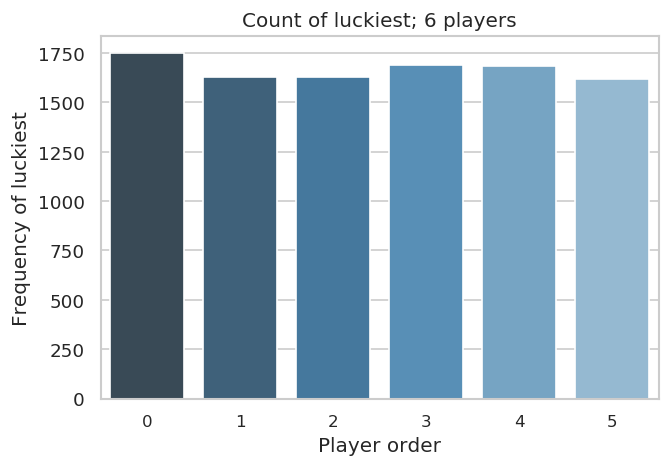

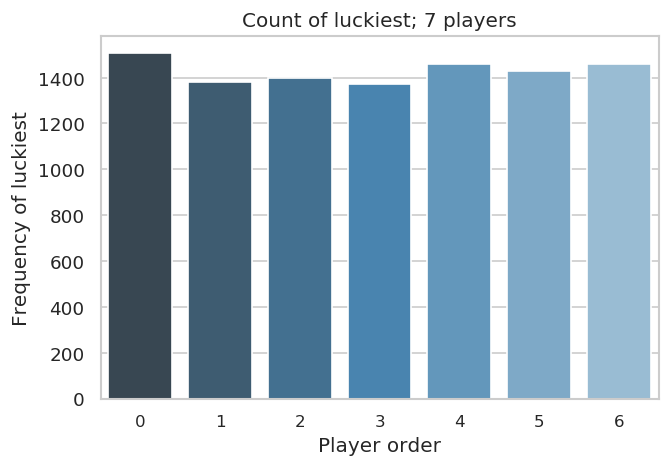

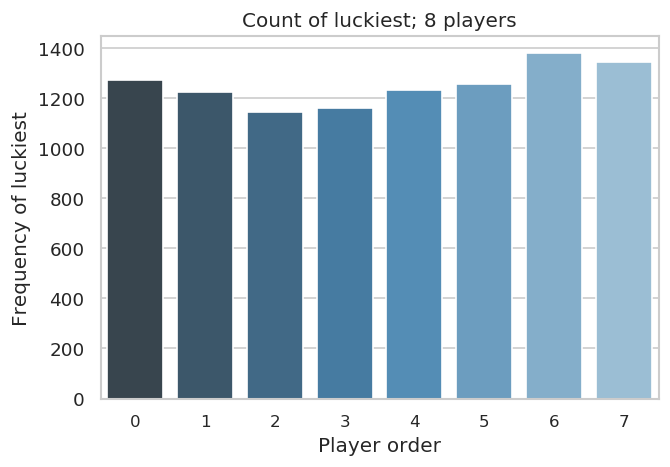

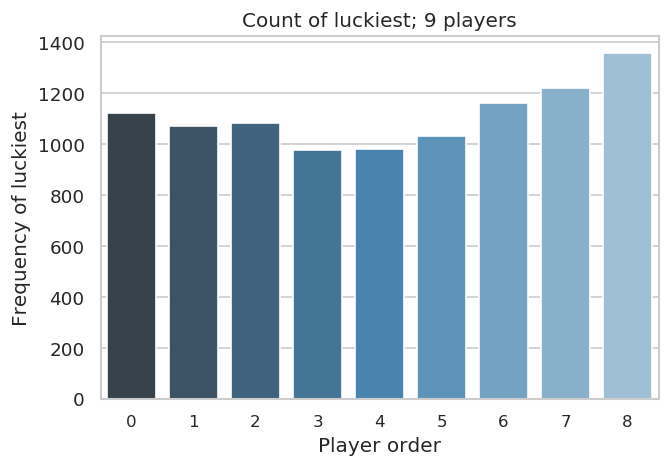

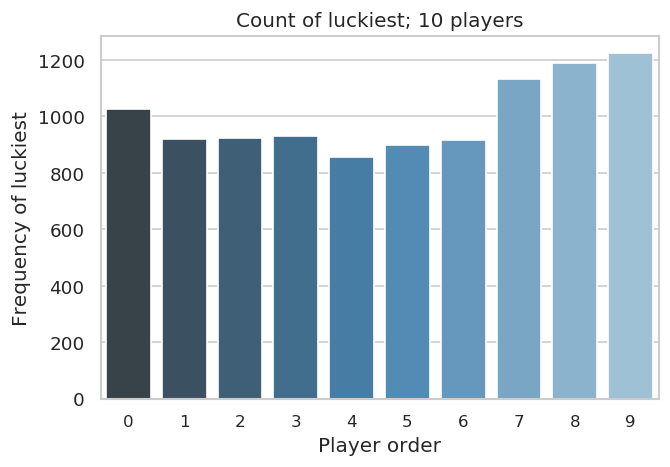

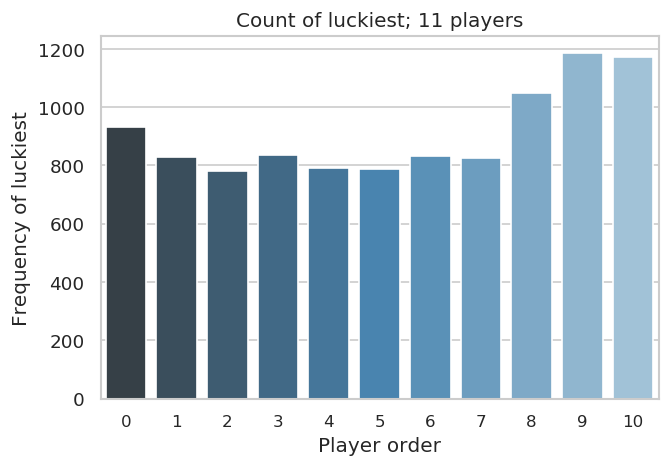

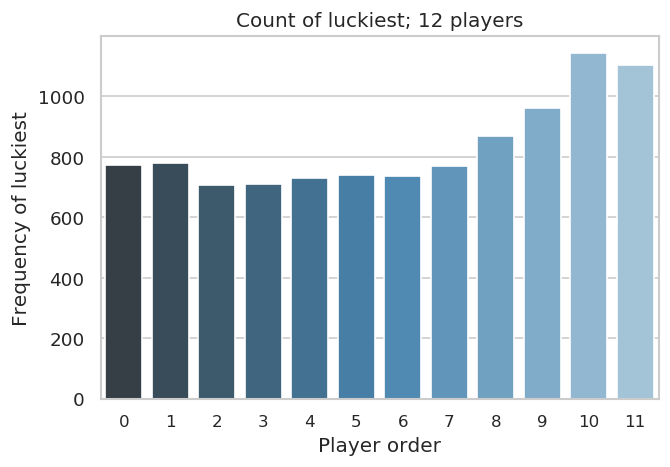

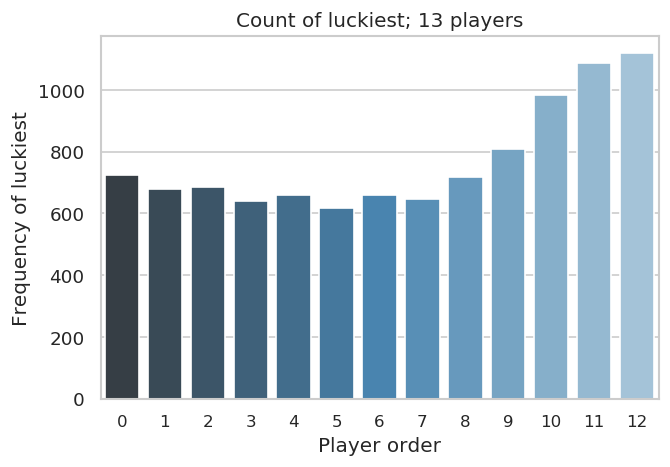

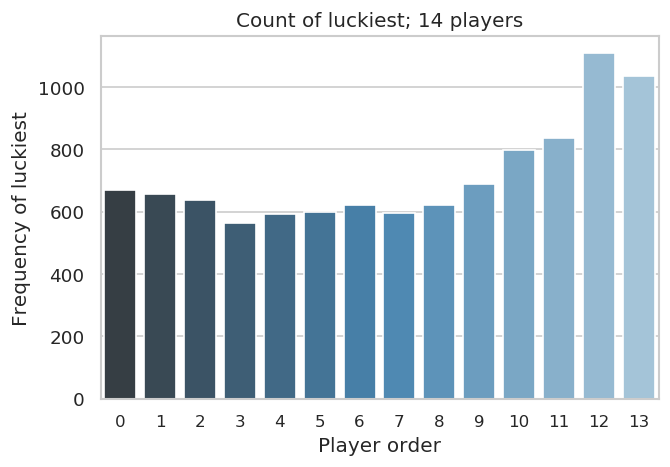

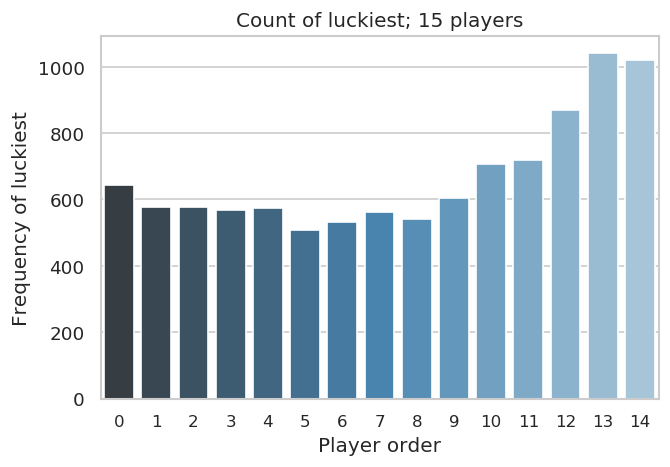

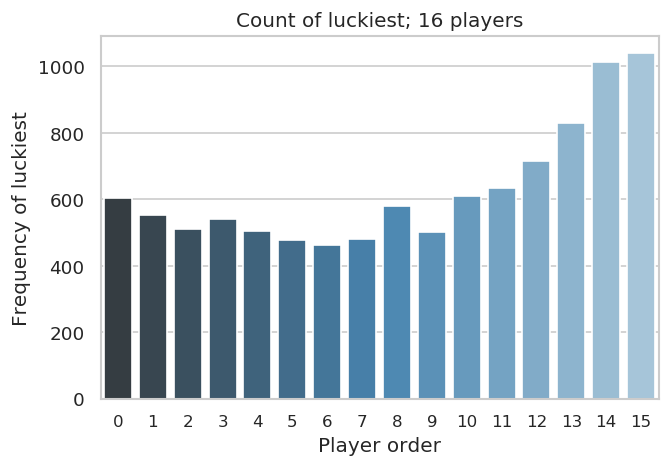

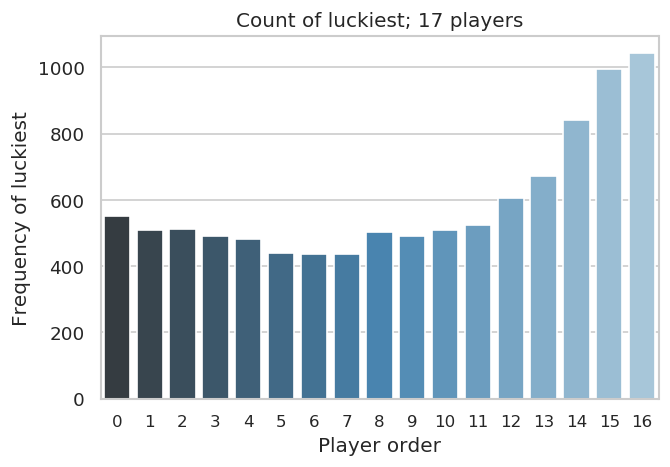

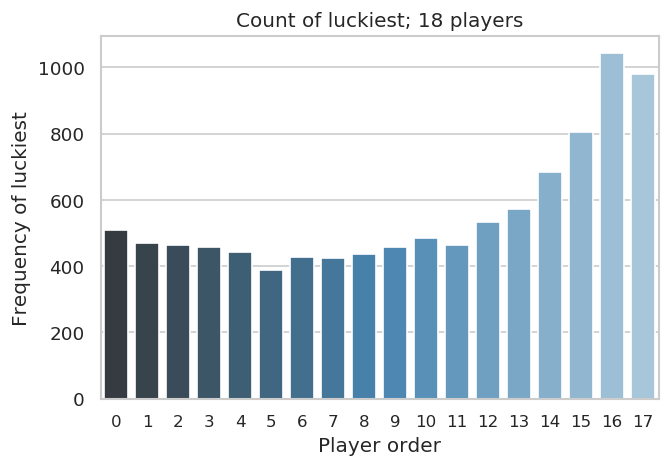

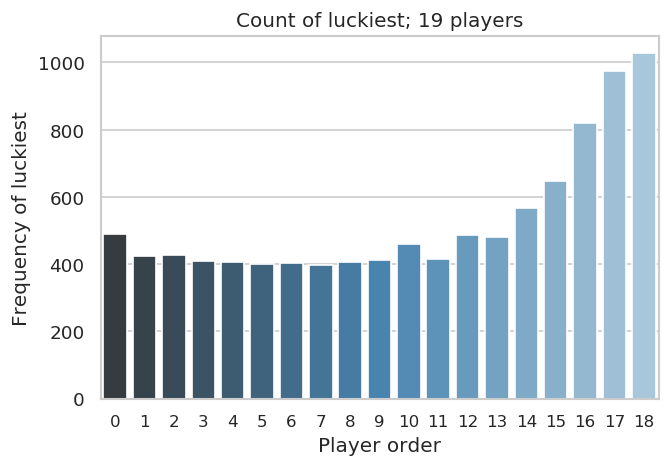

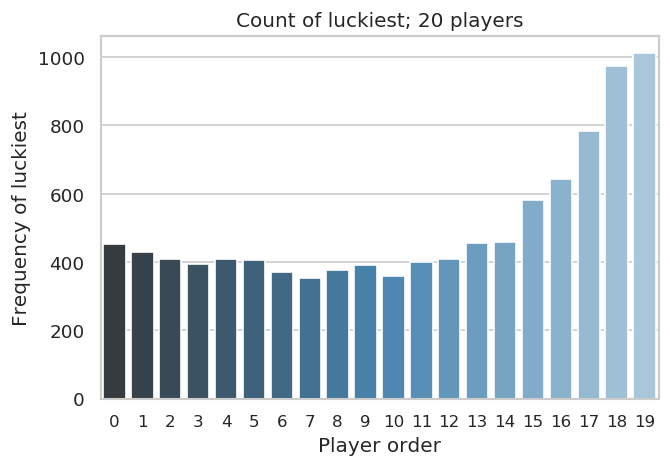

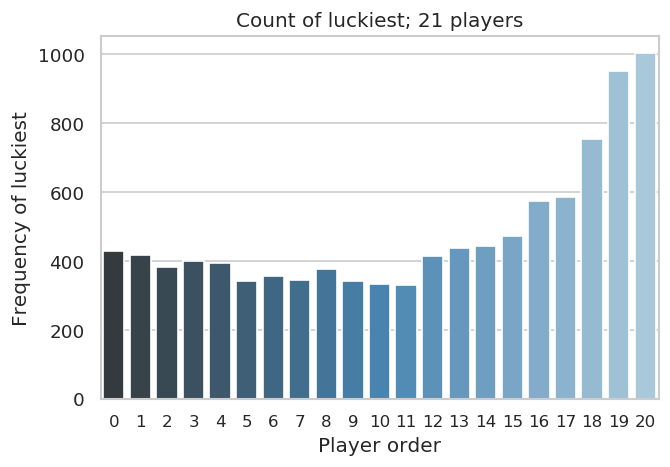

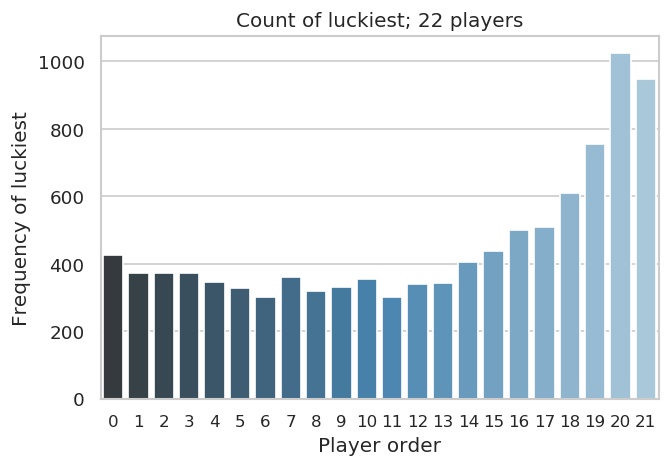

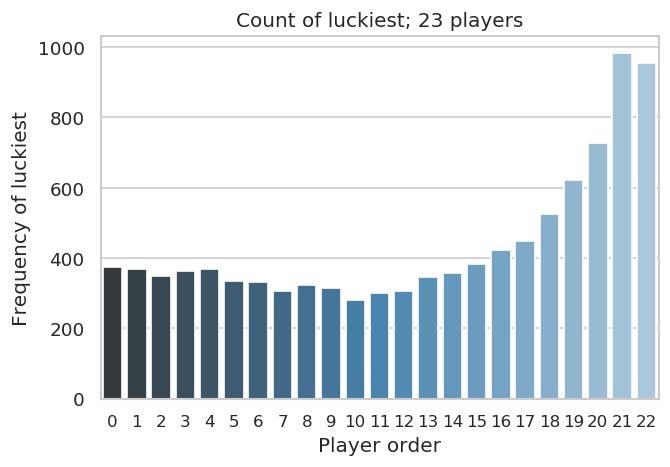

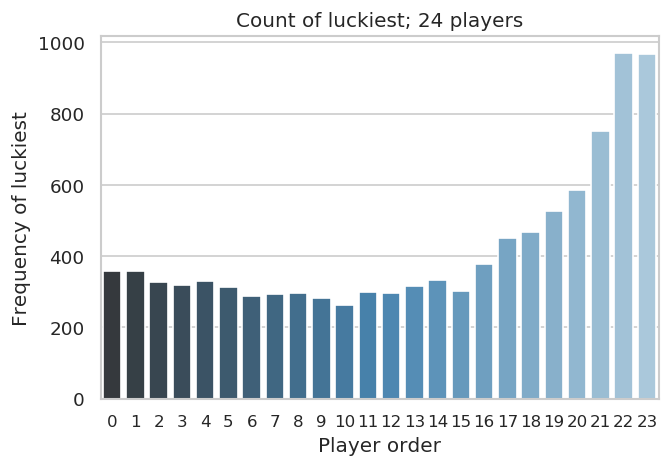

In [7]:
n_trials = 10000
money = 66.0
for n_players in range(3, 25):
    data = sim_trials(n_trials, n_players, money)
    plot_lucky(data)
